# Arabic Book Recommendation System

## Project Team
### Students
- Raghad Almutairi (رغد المطيري)
- Shooq Alqurashi (شوق القريشي)
- Haifa Alsudairi (هيفاء السديري)
- Batool Alfawzan (بتول الفوزان)
- Norah Alarifi (نوره العريفي)

**Academic Institution:** King Saud University

**Course:** SWE 485

**Semester:** 2025 Second Semester

## Project Overview
This project aims to develop a recommendation system for Arabic books using the Jamalon bookstore dataset.
The system will help users discover relevant books based on various attributes like genre, price, and content,
addressing the unique challenges of Arabic book discovery and classification.

## Project Motivation
### 1. Market Need
- Limited availability of sophisticated recommendation systems for Arabic books
- Growing demand for personalized book discovery in the Arabic literary market
- Need for better organization and accessibility of Arabic literary content

### 2. Technical Challenges
- Handling Arabic text processing and classification
- Managing bilingual content and mixed-language entries
- Dealing with unique Arabic publishing patterns and categorization

### 3. Cultural Impact
- Promoting Arabic literature and knowledge dissemination
- Supporting Arabic content digitization efforts
- Enhancing accessibility to Arabic literary resources

## Dataset Description
**Source:** Jamalon Online Bookstore  
**Size:** 8980 books

### Features
- Unique ID: A unique identifier for each book (Numerical).
- Title: The name of the book (Text).
- Author: The author's name (Text).
- Description: A brief description of the book (Text)
- Pages: The total number of pages in the book (Numerical)
- Publication Year: The year the book was published (Numerical)
- Publisher: The name of the publisher (Categorical).
- Cover: The cover type, such as Paperback or Hardcover (Categorical).
- Category: The main category of the book (e.g., Literature, Islamic Books) (Categorical).
- Subcategory: A more specific classification under each category (Categorical).
- Price: The price of the book (Numerical).

The Category and Subcategory columns act as classification labels, organizing books into different genres. These labels are useful for building the recommendation model based on user preferences.

---


In [4]:
# 1. Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from langdetect import detect
import re
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# 2. Data Cleaning Functions
def clean_arabic_text(text):
    """Clean Arabic text by removing diacritics, punctuation, and extra spaces."""
    if pd.isna(text):
        return ''
    text = str(text)
    # Remove Arabic diacritics
    text = re.sub(r'[\u0617-\u061A\u064B-\u0652]', '', text)
    # Remove punctuation and special characters
    text = re.sub(r"[!\"#\$%&'\(\)\*\+,\-./:;<=>?@\[\]\\^_`{|}~،؛؟«»]", '', text)
    # Remove extra spaces
    return re.sub(r'\s+', ' ', text).strip()

def is_english(text):
    """Check if text contains English characters."""
    if pd.isna(text):
        return False
    return bool(re.compile(r'[a-zA-Z]').search(str(text)))

def choose_best_duplicate(group):
    """Select the best version among duplicates based on specific criteria."""
    if len(group) == 1:
        return group.iloc[0]
    
    # Priority 1: Keep non-zero price
    non_zero_prices = group[group['Price'] > 0]
    if not non_zero_prices.empty:
        return non_zero_prices.sort_values('Price').iloc[0]
    
    # Priority 2: Most recent publication
    if group['Publication year'].nunique() > 1:
        return group.sort_values('Publication year', ascending=False).iloc[0]
    
    # Priority 3: Longest description
    group['desc_length'] = group['Description'].fillna('').str.len()
    return group.sort_values('desc_length', ascending=False).iloc[0]

# 3. Category Mapping
CATEGORY_MAP = {
    "الأدب والخيال": "0000000000001",
    "الكتب الإسلامية": "0000000000010",
    "الاقتصاد والأعمال": "0000000000100",
    "الفلسفة": "0000000001000",
    "الصحافة والإعلام": "0000000010000",
    "الكتب السياسية": "0000000100000",
    "العلوم والطبيعة": "0000001000000",
    "الأسرة والطفل": "0000010000000",
    "السير والمذكرات": "0000100000000",
    "الفنون": "0001000000000",
    "التاريخ والجغرافيا": "0010000000000",
    "الرياضة والتسلية": "0100000000000",
    "الشرع والقانون": "1000000000000"
}

class BookDataPreprocessor:
    def __init__(self, file_path):
        """Initialize preprocessor with file path."""
        self.file_path = file_path
        self.df = None
        self.clean_df = None
        self.label_encoder = LabelEncoder()

    def load_data(self):
        """Load the dataset from file."""
        self.df = pd.read_csv(self.file_path)
        print(f"Loaded {len(self.df)} rows from dataset")
        return self

    def remove_unnecessary_columns(self):
        """Remove unwanted columns from dataset."""
        self.clean_df = self.df.drop(columns=['Unnamed: 0', 'Cover'], errors='ignore')
        return self

    def handle_duplicates(self):
        """Remove duplicate entries while keeping the best version."""
        initial_count = len(self.clean_df)
        self.clean_df = (self.clean_df.groupby(['Title', 'Publisher'], 
                                              as_index=False, 
                                              group_keys=False)
                        .apply(choose_best_duplicate)
                        .reset_index(drop=True))
        print(f"Removed {initial_count - len(self.clean_df)} duplicate entries")
        return self

    def clean_text_fields(self):
        """Clean text fields in the dataset."""
        self.clean_df['Title'] = self.clean_df['Title'].apply(clean_arabic_text)
        self.clean_df['Description'] = self.clean_df['Description'].apply(clean_arabic_text)
        return self

    def remove_english_titles(self):
        """Remove books with English titles."""
        initial_count = len(self.clean_df)
        self.clean_df = self.clean_df[~self.clean_df['Title'].apply(is_english)]
        print(f"Removed {initial_count - len(self.clean_df)} English titles")
        return self

    def clean_metadata(self):
        """Clean various metadata fields."""
        initial_count = len(self.clean_df)
        
        # Clean descriptions
        self.clean_df = self.clean_df[
            self.clean_df['Description'].notna() & 
            ~self.clean_df['Description'].astype(str).str.strip().isin(['None', 'nan', ''])
        ]

        # Clean authors
        self.clean_df = self.clean_df[
            ~self.clean_df['Author'].astype(str).str.strip().isin(['لا يوجد', 'None', 'nan', '']) & 
            self.clean_df['Author'].notna()
        ]

        # Clean publication years
        self.clean_df = self.clean_df[
            (self.clean_df['Publication year'] != 0) & 
            self.clean_df['Publication year'].notna() & 
            (self.clean_df['Publication year'].between(1800, 2024))
        ]

        print(f"Removed {initial_count - len(self.clean_df)} rows with invalid metadata")
        return self

    def encode_categorical_variables(self):
        """Encode categorical variables using LabelEncoder."""
        for column in ['Author', 'Publisher', 'Subcategory']:
            self.clean_df[column] = self.label_encoder.fit_transform(
                self.clean_df[column].astype(str)
            )
        return self

    def map_categories(self):
        """Map categories to their binary representations."""
        self.clean_df['Category'] = self.clean_df['Category'].map(CATEGORY_MAP)
        return self

    def add_derived_features(self):
        """Add derived features like page ranges."""
        bins = [0, 50, 100, 150, 200, float('inf')]
        labels = ['0-50', '50-100', '100-150', '150-200', '200+']
        self.clean_df['Page Range'] = pd.cut(
            self.clean_df['Pages'], 
            bins=bins, 
            labels=labels, 
            right=False
        )
        return self

    def save_processed_data(self, output_path):
        """Save the processed dataset."""
        self.clean_df.to_csv(output_path, index=False, encoding='utf-8-sig')
        print(f"Saved processed dataset to {output_path}")
        return self

    def visualize_data(self):
       """Create visualizations of the processed data."""
       # Use a default style instead of seaborn
       plt.style.use('default')
    
       fig = plt.figure(figsize=(15, 10))

    # Book Count by Category
       plt.subplot(2, 2, 1)
       sns.countplot(data=self.clean_df, x='Category')
       plt.title("Book Count by Category")
       plt.xticks(rotation=45)

    # Publication Year vs Price
       plt.subplot(2, 2, 2)
       sns.scatterplot(data=self.clean_df, x='Publication year', y='Price', alpha=0.5)
       plt.title("Publication Year vs Price")

    # Average Price by Category
       plt.subplot(2, 2, 3)
       self.clean_df.groupby('Category')['Price'].mean().plot(kind='bar')
       plt.title("Average Price by Category")
       plt.xticks(rotation=45)

    # Pages vs Price
       plt.subplot(2, 2, 4)
       sns.boxplot(data=self.clean_df, x='Page Range', y='Price')
       plt.title("Price Distribution by Page Range")
       plt.xticks(rotation=45)

       plt.tight_layout()
       plt.show()
       return self

    def process(self, output_path):
        """Execute the complete preprocessing pipeline."""
        return (self.load_data()
                .remove_unnecessary_columns()
                .handle_duplicates()
                .clean_text_fields()
                .remove_english_titles()
                .clean_metadata()
                .encode_categorical_variables()
                .map_categories()
                .add_derived_features()
                .save_processed_data(output_path)
                .visualize_data())

# Execute the preprocessing pipeline
if __name__ == "__main__":
    preprocessor = BookDataPreprocessor('/home/nouarif4/Downloads/jamalon dataset.csv')
    preprocessor.process("~/Downloads/outputnotebook.csv")

ModuleNotFoundError: No module named 'langdetect'

## Supervised Learning Models

In this phase, we aim to predict suitable book categories based on their Arabic descriptions using supervised machine learning models.

---
Initially, our goal was to build a book recommendation system using structured data like price, genre, and category.

after discussions with the course instructors, we shifted our focus toward  
classifying books based on their descriptions, which is more challenging and text-based.

We used text embeddings as features and applied two supervised learning models:

- Support Vector Machine (SVM)
- CatBoost Classifier

These models were selected based on their strengths in handling Arabic text, high-dimensional vectors, and categorical data.

###  Why We Selected SVM and CatBoost

####  Support Vector Machine (SVM)

SVM was chosen for its effectiveness in handling high-dimensional spaces (like BERT embeddings).  
It provides strong generalization, reduces overfitting, and works well on medium-sized datasets.

Reasons:
- Performs well with BERT-generated TF-IDF-like embeddings.
- Strong performance in text categorization.
- Simple yet powerful baseline model.

---

####  CatBoost Classifier

CatBoost is ideal for combining structured and unstructured data.  
It supports Arabic text natively and handles categorical features without heavy preprocessing.

Reasons:
- Supports Arabic text natively.
- No need for one-hot encoding.
- Can combine text (description/title) + structured features (category).
- Regularization reduces overfitting in deep trees.

##  Model 1: Support Vector Machine (SVM)

In this section, we trained an SVM classifier to predict book categories based on Arabic text descriptions.  
We used the asafaya/bert-base-arabic model to generate sentence embeddings using mean pooling, then passed those embeddings into an SVM with a linear kernel.

---

In [ ]:
# Step 1: Load the cleaned dataset and define a Dataset class for BERT inputs
import pandas as pd
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

# Load the cleaned CSV from Phase 1
file_path = "outputnotebook.csv"
df = pd.read_csv(file_path, encoding="utf-8-sig")

# Dataset class to prepare inputs for BERT
class TextDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            max_length=self.max_length,
            padding='max_length',
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze()
        }


In [3]:
# Step 2: Define a function to convert Arabic text to BERT embeddings using mean pooling

def convert_to_embeddings(df, column_names, max_length=512, batch_size=32, device='cuda' if torch.cuda.is_available() else 'cpu'):
  
    # Load model and tokenizer once
    print("Loading model and tokenizer...")
    tokenizer = AutoTokenizer.from_pretrained('asafaya/bert-base-arabic')
    model = AutoModel.from_pretrained('asafaya/bert-base-arabic')
    model = model.to(device)
    model.eval()
    
    for column_name in column_names:
        print(f"\nProcessing column: {column_name}")
        
        # Create dataset and dataloader
        texts = df[column_name].tolist()
        dataset = TextDataset(texts, tokenizer, max_length)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
        
        # Process batches
        embeddings = []
        with torch.no_grad():
            for batch in tqdm(dataloader, desc="Generating embeddings"):
                # Move batch to device
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                
                # Generate embeddings
                outputs = model(input_ids, attention_mask=attention_mask)
                
                # Compute mean pooling
                mask = attention_mask.unsqueeze(-1).expand(outputs.last_hidden_state.size()).float()
                masked_embeddings = outputs.last_hidden_state * mask
                summed = torch.sum(masked_embeddings, 1)
                counts = torch.clamp(mask.sum(1), min=1e-9)
                mean_pooled = summed / counts
                
                # Move to CPU and convert to numpy
                embeddings.append(mean_pooled.cpu().numpy())
        
        # Concatenate all batches
        all_embeddings = np.concatenate(embeddings, axis=0)
        
        # Store embeddings in DataFrame
        df[f"{column_name}_embedded"] = list(all_embeddings)
        
        print(f"Completed embedding generation for {column_name}")
    
    return df

In [4]:
def decode_categories(df):

    # Define the category mapping
    category_map = {
        "الأدب والخيال": "1",
        "الكتب الإسلامية": "10",
        "الاقتصاد والأعمال": "100",
        "الفلسفة": "1000",
        "الصحافة والإعلام": "10000",
        "الكتب السياسية": "100000",
        "العلوم والطبيعة": "1000000",
        "الأسرة والطفل": "10000000",
        "السير والمذكرات": "100000000",
        "الفنون": "1000000000",
        "التاريخ والجغرافيا": "10000000000",
        "الرياضة والتسلية": "100000000000",
        "الشرع والقانون": "1000000000000"
    }
    
    # Create reversed mapping
    reversed_category_map = {v: k for k, v in category_map.items()}
    
    # Convert category values to string to ensure proper matching
    df['Category'] = df['Category'].astype(str)
    
    # Function to safely map categories
    def safe_map_category(x):
        if pd.isna(x) or x == 'nan':
            return np.nan
        
        # Convert the input to a simple string of the number
        x_str = str(int(x))  # This removes leading zeros and converts to simple number string
        
        return reversed_category_map.get(x_str, x)
    
    # Apply the mapping
    df['Category_original'] = df['Category'].apply(safe_map_category)
    
    return df

print(df[['Category']].head(3))
df = decode_categories(df)
print(df[['Category']].head(3))
print(df[['Category_original']].head(3))

   Category
0     10000
1        10
2  10000000
   Category
0     10000
1        10
2  10000000
  Category_original
0  الصحافة والإعلام
1   الكتب الإسلامية
2     الأسرة والطفل


In [12]:
import os
import pickle

# Get absolute path of the file
pkl_path = os.path.abspath("../label_encoder_Subcategory.pkl")
print("Using path:", pkl_path)
# Load the encoder
with open(pkl_path, "rb") as f:
    label_encoder = pickle.load(f)
# Decode subcategory
df['Subcategory_original'] = label_encoder.inverse_transform(df['Subcategory'])
# Display a sample
df[['Subcategory', 'Subcategory_original']].head()

Using path: c:\Users\Raghad\Documents\books\label_encoder_Subcategory.pkl


c:\Users\Raghad\anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.6.1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


,Subcategory,Subcategory_original
0,65,الندوات والمؤتمرات
1,54,القرآن وعلومه
2,71,شؤون المرأة
3,74,علم النبات
4,68,تاريخ الأدب


In [13]:
# we will decide the max_length based on the following results 
# Calculate the number of words in each text
df['word_count_Description'] = df['Description'].apply(lambda x: len(x.split()))
df['word_count_Title'] = df['Title'].apply(lambda x: len(x.split()))
# Analyze the distribution
print(df['word_count_Description'].describe())
print(df['word_count_Title'].describe())
df.drop(['word_count_Title', 'word_count_Description'], axis=1)

df = convert_to_embeddings(df, 
                         column_names=['Title'], 
                         max_length=20, 
                         batch_size=32)
#%75 of descriptions will be covered and 128 will avoid excessive padding for shorter descriptions
# and will truncates very long descriptions
df = convert_to_embeddings(df, 
                         column_names=["Description"], 
                         max_length=128, 
                         batch_size=32)

#Flatten embeddings into separate columns
df = pd.concat([df.drop(['Title', 'Description'], axis=1),
                df['Title'].apply(pd.Series),
                df['Description'].apply(pd.Series)], axis=1)

count    3299.000000
mean       94.642316
std        95.139226
min         2.000000
25%        56.000000
50%        63.000000
75%        72.000000
max      1374.000000
Name: word_count_Description, dtype: float64
count    3299.000000
mean        4.825402
std         2.597022
min         1.000000
25%         3.000000
50%         4.000000
75%         6.000000
max        20.000000
Name: word_count_Title, dtype: float64
Loading model and tokenizer...

Processing column: Title


Generating embeddings: 100%|██████████| 104/104 [02:47<00:00,  1.61s/it]


Completed embedding generation for Title
Loading model and tokenizer...

Processing column: Description


Generating embeddings: 100%|██████████| 104/104 [18:49<00:00, 10.86s/it]


Completed embedding generation for Description


In [14]:
# the end result of the dataset in the training we will use Subcategory_original, Category_original
# in catogory format after decoding to utilize catboost 
print (df.head(1))

   Author  Pages  Publication year  Publisher Category  Subcategory  Price  \
0    2073     40              2003        145    10000           65  16.88   

  Page Range Category_original Subcategory_original  word_count_Description  \
0       0-50  الصحافة والإعلام   الندوات والمؤتمرات                      71   

   word_count_Title                                     Title_embedded  \
0                 7  [0.6406202, -0.59858966, 0.0932962, -0.492798,...   

                                Description_embedded  \
0  [0.47871357, -0.15091306, 0.24697728, -0.48251...   

                                                 0  \
0  التشبيك وميثاق الممارسة في عمل المنظمات الأهلية   

                                                   0  
0  تقرير يوثق أعمال ورشة عمل 1995 عن محاولة صياغة...  


In [15]:
# Step 3: Train and evaluate the SVM model using BERT-based description embeddings
from sklearn.svm import SVC 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from transformers import AutoTokenizer, AutoModel
import torch
import pandas as pd
import numpy as np

# Load the tokenizer and model for Arabic BERT
tokenizer = AutoTokenizer.from_pretrained("asafaya/bert-base-arabic")
bert_model = AutoModel.from_pretrained("asafaya/bert-base-arabic").to("cuda" if torch.cuda.is_available() else "cpu")

# 1️. Prepare the dataset for SVM
X = df['Description_embedded'].apply(np.array).tolist()   # Convert embeddings column to lists
X = np.array(X)  # Convert the list to a numpy array

# The target variable (category labels)
y = df['Category_original']

# 2. Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Initialize the SVM model
svm_model = SVC(kernel="linear", probability=True, random_state=42)

# 4. Train the model
svm_model.fit(X_train, y_train)

# 4. **Perform Cross-Validation**
cross_val_scores = cross_val_score(svm_model, X_train, y_train, cv=5)  # 5-fold cross-validation
print(f"Cross-validation scores: {cross_val_scores}")
print(f"Mean CV score: {cross_val_scores.mean()}")

# 5. Calculate Training Accuracy
y_train_pred = svm_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_accuracy:.4f}")

# 6. Make predictions on the test set
y_pred = svm_model.predict(X_test)

# Save predictions to a CSV file
pd.DataFrame(y_pred, columns=['Predictions']).to_csv("y_pred_svm.csv", index=False)

# 7. Calculate Test Accuracy
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

# 9. Classify a new description (example)
example_description = "طفل"  # Example new description
device = "cuda" if torch.cuda.is_available() else "cpu"

# Convert the new description into model-compatible input using the tokenizer
example_inputs = tokenizer(example_description, truncation=True, max_length=128, padding='max_length', return_tensors='pt').to(device)

with torch.no_grad():
    outputs = bert_model(example_inputs['input_ids'], attention_mask=example_inputs['attention_mask'])
    mask = example_inputs['attention_mask'].unsqueeze(-1).expand(outputs.last_hidden_state.size()).float()
    masked_embeddings = outputs.last_hidden_state * mask
    summed = torch.sum(masked_embeddings, dim=1)
    counts = torch.clamp(mask.sum(dim=1), min=1e-9)
    mean_pooled = summed / counts  # final embedding

# Convert embedding to NumPy for SVM prediction
example_embedding = mean_pooled.cpu().numpy()

# 10. Predict the category using the trained SVM model
example_category = svm_model.predict(example_embedding)
print(f"Predicted Category: {example_category}")

Cross-validation scores: [0.56060606 0.59659091 0.59659091 0.61174242 0.57874763]
Mean CV score: 0.5888555862227589
Training Accuracy: 0.9913
Test Accuracy: 0.6212
Predicted Category: ['الأسرة والطفل']


### Model 2: CatBoost Classifier

In this section, we trained a CatBoost classifier to predict Arabic book categories using a combination of structured and unstructured features.  
We used the `asafaya/bert-base-arabic` model to generate sentence embeddings from both titles and descriptions.  


---


In [1]:
### Step 1: Load cleaned dataset and define embedding function  
## In this step, we import all necessary libraries, load the cleaned dataset from Phase 1,  
## initialize the Arabic BERT model (`asafaya/bert-base-arabic`), and define functions to convert Arabic text into sentence embeddings using mean pooling.

import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import joblib
import pickle

# ----------------- Load dataset and BERT Model for Embeddings -----------------

file_path = "outputnotebook.csv"
df = pd.read_csv(file_path, encoding="utf-8-sig")
# Initialize tokenizer, device
bert_model_name = 'asafaya/bert-base-arabic'
tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
bert_model = AutoModel.from_pretrained(bert_model_name)

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model.to(device)
bert_model.eval()

# ----------------- Embedding with the use of batching for faster preformence -----------------
class TextDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            max_length=self.max_length,
            padding='max_length',
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),  # Remove batch dimension
            'attention_mask': encoding['attention_mask'].squeeze(0)
        }

def mean_pooling(model_output, attention_mask):
    last_hidden_state = model_output.last_hidden_state
    mask = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
    summed = torch.sum(last_hidden_state * mask, dim=1)
    counts = torch.clamp(mask.sum(dim=1), min=1e-9)
    return summed / counts  # (batch_size, hidden_dim)

def convert_to_embeddings(df, column_names, model_name="asafaya/bert-base-arabic", max_length=512, batch_size=32, device='cuda' if torch.cuda.is_available() else 'cpu'):
    
    print("Loading model and tokenizer...")
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name).to(device)
    model.eval()
    
    for column_name in column_names:
        print(f"\nProcessing column: {column_name}")
        
        # Ensure all text data is string format
        texts = df[column_name].astype(str).tolist()
        
        # Create dataset and dataloader
        dataset = TextDataset(texts, tokenizer, max_length)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

        embeddings = []
        with torch.no_grad():
            for batch in tqdm(dataloader, desc="Generating embeddings"):
                # Move input tensors to GPU
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                
                # Get model output
                outputs = model(input_ids, attention_mask=attention_mask)
                
                # Apply mean pooling
                sentence_embeddings = mean_pooling(outputs, attention_mask)
                
                # Move to CPU and store embeddings
                embeddings.append(sentence_embeddings.cpu().numpy())

        # Store embeddings in DataFrame
        df[f"{column_name}_embedded"] = list(np.concatenate(embeddings, axis=0))
        print(f"Completed embedding generation for {column_name}")
    
    return df

In [2]:
# -----------------  Decode the catgories -----------------

def decode_categories(df):

    # Define the category mapping
    category_map = {
        "الأدب والخيال": "1",
        "الكتب الإسلامية": "10",
        "الاقتصاد والأعمال": "100",
        "الفلسفة": "1000",
        "الصحافة والإعلام": "10000",
        "الكتب السياسية": "100000",
        "العلوم والطبيعة": "1000000",
        "الأسرة والطفل": "10000000",
        "السير والمذكرات": "100000000",
        "الفنون": "1000000000",
        "التاريخ والجغرافيا": "10000000000",
        "الرياضة والتسلية": "100000000000",
        "الشرع والقانون": "1000000000000"
    }
    
    # Create reversed mapping
    reversed_category_map = {v: k for k, v in category_map.items()}
    
    # Convert category values to string to ensure proper matching
    df['Category'] = df['Category'].astype(str)
    
    # Function to safely map categories
    def safe_map_category(x):
        if pd.isna(x) or x == 'nan':
            return np.nan
        
        # Convert the input to a simple string of the number
        x_str = str(int(x))  # This removes leading zeros and converts to simple number string
        
        return reversed_category_map.get(x_str, x)
    
    # Apply the mapping
    df['Category_original'] = df['Category'].apply(safe_map_category)
    
    return df

print(df[['Category']].head(3))
df = decode_categories(df)
print(df[['Category']].head(3))
print(df[['Category_original']].head(3))

   Category
0     10000
1        10
2  10000000
   Category
0     10000
1        10
2  10000000
  Category_original
0  الصحافة والإعلام
1   الكتب الإسلامية
2     الأسرة والطفل


In [20]:
# ----------------- Merge Title & Description -----------------
# we have merged them for higher accuracy result of the training model
df['Title_Description'] = df['Title'] + " " + df['Description'] 

# ----------------- max_length descion making process -----------------

# we will decide the max_length based on the following results 
# Calculate the number of words in each text
df['word_count_Title_Description'] = df['Title_Description'].apply(lambda x: len(x.split()))

# Analyze the distribution
print(df['word_count_Title_Description'].describe())
df = df.drop(['word_count_Title_Description'], axis=1)


#%75 of 'Title_Description' will be covered and 128 will avoid excessive padding for shorter descriptions
# and will truncates very long descriptions
df = convert_to_embeddings(df, 
                         column_names=['Title_Description'], 
                         max_length=128, 
                         batch_size=32)


#Flatten embeddings into separate columns
df = pd.concat([df.drop(['Title_Description'], axis=1),
                df['Title_Description'].apply(pd.Series),], axis=1)

count    3299.000000
mean       99.467717
std        95.465457
min         5.000000
25%        60.000000
50%        67.000000
75%        78.000000
max      1377.000000
Name: word_count_Title_Description, dtype: float64
Loading model and tokenizer...

Processing column: Title_Description


Generating embeddings: 100%|██████████| 104/104 [08:15<00:00,  4.77s/it]


Completed embedding generation for Title_Description


In [21]:
# the end result of the dataset in the training we will use Category_original
# in catogory format after decoding to utilize catboost 
print (df.head(1))

                                             Title  Author  \
0  التشبيك وميثاق الممارسة في عمل المنظمات الأهلية    2073   

                                         Description  Pages  Publication year  \
0  تقرير يوثق أعمال ورشة عمل 1995 عن محاولة صياغة...     40              2003   

   Publisher Category  Subcategory  Price Page Range Category_original  \
0        145    10000           65  16.88       0-50  الصحافة والإعلام   

                          Title_Description_embedded  \
0  [0.4847842, -0.12686887, 0.1268857, -0.4015937...   

                                                   0  
0  التشبيك وميثاق الممارسة في عمل المنظمات الأهلي...  


In [4]:
# ----------------- Embedding Creation (ADD THIS FIRST) -----------------
from sentence_transformers import SentenceTransformer

# Load the embedding model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Create the embedded vectors
df['Title_Description_embedded'] = df['Title_Description'].apply(lambda x: model.encode(x))

# ----------------- Train CatBoost Classifier -----------------

# We Used only the embeddings for Description and title as features and Category_original as the target
X = df['Title_Description_embedded'].apply(np.array).tolist()  # Only use Description embeddings as features
X = np.array(X)  # Convert the list to a numpy array

# The target variable is 'Category_original'
y = df['Category_original']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the CatBoost model
catboost_model = CatBoostClassifier(iterations=500,  # Number of trees
                          depth=6,  # Depth of each tree
                          learning_rate=0.05,  # Learning rate
                          loss_function='MultiClass',  # Multi-class classification
                          cat_features=[],  # No categorical features in this case
                          early_stopping_rounds=5,
                          )

# Train the model with validation set
catboost_model.fit(X_train, 
                   y_train, 
                   eval_set=(X_test, y_test),  # Specify validation data
                   verbose=200)  # Print training progress every 200 iterations

# Calculate training accuracy
train_accuracy = accuracy_score(y_train, catboost_model.predict(X_train))
print(f"Training Accuracy: {train_accuracy:.4f}")

# Make predictions on the test set
y_pred = catboost_model.predict(X_test)

# Save predictions to a CSV file
pd.DataFrame(y_pred, columns=['Predictions']).to_csv("y_pred_catboost.csv", index=False)

# Save trained model
joblib.dump(catboost_model, "catboost_classifier.pkl")

# Evaluate the model (Test Accuracy)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

ModuleNotFoundError: No module named 'sentence_transformers'

In [23]:
from sklearn.model_selection import cross_val_score

# Cross-validation for CatBoost
cross_val_scores = cross_val_score(catboost_model, X_train, y_train, cv=5)  # 5-fold cross-validation

print("Cross-validation scores (first 5):", cross_val_scores[:5])
print("Cross-validation scores (last 5):", cross_val_scores[-5:])
print(f"Mean CV score: {cross_val_scores.mean():.4f}")


0:	learn: 2.5195859	total: 1.27s	remaining: 10m 35s
1:	learn: 2.4826376	total: 2.56s	remaining: 10m 37s
2:	learn: 2.4368976	total: 3.88s	remaining: 10m 43s
3:	learn: 2.4063440	total: 5.45s	remaining: 11m 15s
4:	learn: 2.3689126	total: 6.89s	remaining: 11m 22s
5:	learn: 2.3327883	total: 8.42s	remaining: 11m 33s
6:	learn: 2.2993407	total: 9.95s	remaining: 11m 40s
7:	learn: 2.2710872	total: 11.3s	remaining: 11m 35s
8:	learn: 2.2367428	total: 12.7s	remaining: 11m 31s
9:	learn: 2.2098137	total: 14.2s	remaining: 11m 35s
10:	learn: 2.1788338	total: 15.6s	remaining: 11m 33s
11:	learn: 2.1510802	total: 17s	remaining: 11m 31s
12:	learn: 2.1267024	total: 18.6s	remaining: 11m 38s
13:	learn: 2.1005105	total: 20.5s	remaining: 11m 52s
14:	learn: 2.0711184	total: 22.4s	remaining: 12m 3s
15:	learn: 2.0431959	total: 24.3s	remaining: 12m 14s
16:	learn: 2.0209614	total: 25.9s	remaining: 12m 16s
17:	learn: 1.9942894	total: 27.6s	remaining: 12m 19s
18:	learn: 1.9765545	total: 29.1s	remaining: 12m 17s
19:	le

In [24]:
# Classify a new description (example)
example_description = "قصص مغامرات للأطفال"

# Tokenize using BERT
example_inputs = tokenizer(
    example_description, truncation=True, max_length=128, padding='max_length', return_tensors='pt'
).to(device)

# Generate embedding
with torch.no_grad():
    outputs = bert_model(example_inputs['input_ids'], attention_mask=example_inputs['attention_mask'])

# Mean Pooling
mask = example_inputs['attention_mask'].unsqueeze(-1).expand(outputs.last_hidden_state.size()).float()
masked_embeddings = outputs.last_hidden_state * mask
summed = torch.sum(masked_embeddings, dim=1)
counts = torch.clamp(mask.sum(dim=1), min=1e-9)
mean_pooled = summed / counts  # Final sentence embedding

# Convert to NumPy (reshape for CatBoost)
example_embedding = mean_pooled.cpu().numpy().reshape(1, -1)

# Predict category using trained CatBoost model
example_category = catboost_model.predict(example_embedding)[0]

print(f"Predicted Category: {example_category}")

Predicted Category: ['الأدب والخيال']


## Performance Analysis and Comparison
In this section, we compare the performance of two models used for Arabic book category classification:

Model 1: Support Vector Machine (SVM)
Model 2: CatBoost Classifier

We evaluate both models based on the following metrics:
Accuracy, F1-Score ,Precision, Recall ,Confusion Matrix abd Cross-Validation Score

At the end, we analyze overfitting/underfitting and highlight which model performs better overall.

In [10]:
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.model_selection import train_test_split

# Load your dataset
file_path = "outputnotebook.csv"
df = pd.read_csv(file_path, encoding="utf-8-sig")

# ----------------- Decode Categories -----------------
def decode_categories(df):
    category_map = {
        "الأدب والخيال": "1",
        "الكتب الإسلامية": "10",
        "الاقتصاد والأعمال": "100",
        "الفلسفة": "1000",
        "الصحافة والإعلام": "10000",
        "الكتب السياسية": "100000",
        "العلوم والطبيعة": "1000000",
        "الأسرة والطفل": "10000000",
        "السير والمذكرات": "100000000",
        "الفنون": "1000000000",
        "التاريخ والجغرافيا": "10000000000",
        "الرياضة والتسلية": "100000000000",
        "الشرع والقانون": "1000000000000"
    }
    
    reversed_category_map = {v: k for k, v in category_map.items()}
    
    df['Category'] = df['Category'].astype(str)
    
    def safe_map_category(x):
        if pd.isna(x) or x == 'nan':
            return np.nan
        x_str = str(int(x))
        return reversed_category_map.get(x_str, x)
    
    df['Category_original'] = df['Category'].apply(safe_map_category)
    return df

# Apply category decoding
df = decode_categories(df)

# ----------------- Combine Title and Description for embeddings -----------------
df['Title_Description'] = df['Title'] + " " + df['Description']

# ----------------- Initialize the BERT model and tokenizer for embeddings -----------------
tokenizer = AutoTokenizer.from_pretrained('asafaya/bert-base-arabic')
model = AutoModel.from_pretrained('asafaya/bert-base-arabic')

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Function to generate embeddings
def generate_embeddings(texts):
    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=128).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()  # Use mean pooling to get embeddings
    return embeddings

# Generate embeddings for the combined Title and Description
title_description_embeddings = generate_embeddings(df['Title_Description'].tolist())

# Store the embeddings as a list in the DataFrame
df['Title_Description_embedded'] = list(title_description_embeddings)

# ----------------- Prepare data for training -----------------
# Now assuming 'Category_original' is the target variable
X = df['Title_Description_embedded'].apply(np.array).tolist()  
X = np.array(X)  # Convert the list to a numpy array

y = df['Category_original']  

# ----------------- Split the data into training and testing sets -----------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ----------------- Save y_test as a CSV file -----------------
y_test_df = pd.DataFrame(y_test)  # Convert to DataFrame for saving
y_test_df.to_csv("y_test.csv", index=False)

print("y_test.csv file saved successfully!")

/usr/local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


y_test.csv file saved successfully!


SVM Model Metrics:
Accuracy: 0.6212
F1-Score: 0.6185
Precision: 0.6218
Recall: 0.6212

SVM Classification Report:
                    precision    recall  f1-score   support

     الأدب والخيال       0.62      0.72      0.67       112
     الأسرة والطفل       0.59      0.60      0.59        50
 الاقتصاد والأعمال       0.67      0.74      0.71        82
التاريخ والجغرافيا       0.25      0.28      0.26        18
  الرياضة والتسلية       0.56      0.45      0.50        11
   السير والمذكرات       0.55      0.48      0.51        44
    الشرع والقانون       0.25      1.00      0.40         1
  الصحافة والإعلام       0.51      0.53      0.52        36
   العلوم والطبيعة       0.73      0.69      0.71        51
           الفلسفة       0.67      0.70      0.68        99
            الفنون       0.00      0.00      0.00         8
   الكتب الإسلامية       0.70      0.62      0.66        74
    الكتب السياسية       0.65      0.50      0.56        74

          accuracy                          

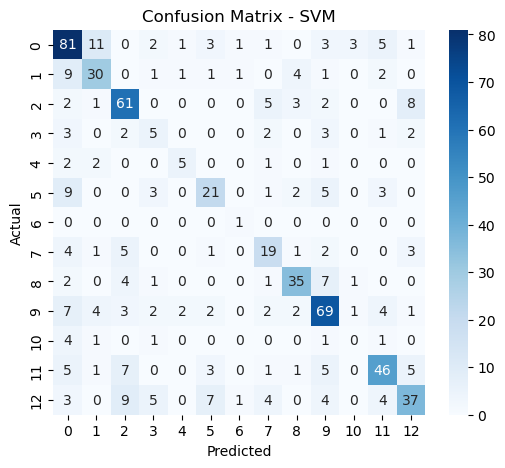

SVM might be overfitting (training accuracy much higher than test accuracy).


In [3]:
#svm analysis
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load test labels and predictions
y_test = pd.read_csv("y_test.csv")
y_pred_svm = pd.read_csv("y_pred_svm.csv")  # Predictions from SVM

# Compute metrics for SVM
accuracy_svm = accuracy_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm, average="weighted")
precision_svm = precision_score(y_test, y_pred_svm, average="weighted", zero_division=1)
recall_svm = recall_score(y_test, y_pred_svm, average="weighted", zero_division=1)

# Display metrics for SVM
print("SVM Model Metrics:")
print(f"Accuracy: {accuracy_svm:.4f}")
print(f"F1-Score: {f1_svm:.4f}")
print(f"Precision: {precision_svm:.4f}")
print(f"Recall: {recall_svm:.4f}")

# Classification Report for SVM
print("\nSVM Classification Report:")
print(classification_report(y_test, y_pred_svm))

# Confusion Matrix for SVM
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - SVM")
plt.show()

# Overfitting/Underfitting check for SVM
train_accuracy_svm = 0.9913  
cv_score_svm = 0.5889  

if train_accuracy_svm - accuracy_svm > 0.1:
    print("SVM might be overfitting (training accuracy much higher than test accuracy).")
elif accuracy_svm < 0.7:
    print("SVM might be underfitting (low test accuracy).")
else:
    print("SVM seems well balanced.")

CatBoost Model Metrics:
Accuracy: 0.6879
F1-Score: 0.6713
Precision: 0.7093
Recall: 0.6879

CatBoost Classification Report:
                    precision    recall  f1-score   support

     الأدب والخيال       0.65      0.84      0.73       112
     الأسرة والطفل       0.67      0.74      0.70        50
 الاقتصاد والأعمال       0.81      0.74      0.78        82
التاريخ والجغرافيا       0.50      0.22      0.31        18
  الرياضة والتسلية       1.00      0.09      0.17        11
   السير والمذكرات       0.71      0.39      0.50        44
    الشرع والقانون       0.00      0.00      0.00         1
  الصحافة والإعلام       0.94      0.44      0.60        36
   العلوم والطبيعة       0.77      0.71      0.73        51
           الفلسفة       0.66      0.83      0.73        99
            الفنون       0.00      0.00      0.00         8
   الكتب الإسلامية       0.71      0.70      0.71        74
    الكتب السياسية       0.60      0.73      0.66        74

          accuracy                

c:\Users\Raghad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Raghad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Raghad\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


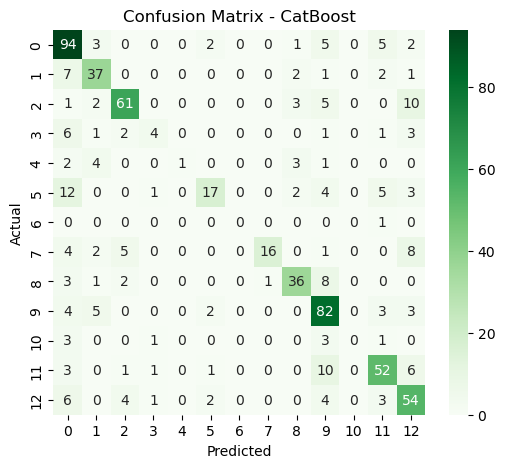

CatBoost might be overfitting (training accuracy much higher than test accuracy).


In [4]:
#catboost analysis
# Load predictions for CatBoost
y_pred_catboost = pd.read_csv("y_pred_catboost.csv")

# Compute metrics for CatBoost
accuracy_catboost = accuracy_score(y_test, y_pred_catboost)
f1_catboost = f1_score(y_test, y_pred_catboost, average="weighted")
precision_catboost = precision_score(y_test, y_pred_catboost, average="weighted", zero_division=1)
recall_catboost = recall_score(y_test, y_pred_catboost, average="weighted", zero_division=1)

# Display metrics for CatBoost
print("CatBoost Model Metrics:")
print(f"Accuracy: {accuracy_catboost:.4f}")
print(f"F1-Score: {f1_catboost:.4f}")
print(f"Precision: {precision_catboost:.4f}")
print(f"Recall: {recall_catboost:.4f}")

# Classification Report for CatBoost
print("\nCatBoost Classification Report:")
print(classification_report(y_test, y_pred_catboost))

# Confusion Matrix for CatBoost
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_catboost), annot=True, cmap="Greens", fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - CatBoost")
plt.show()

# Overfitting/Underfitting check for CatBoost
train_accuracy_catboost = 0.9492 
cv_score_catboost = 0.5484  

if train_accuracy_catboost - accuracy_catboost > 0.1:
    print("CatBoost might be overfitting (training accuracy much higher than test accuracy).")
elif accuracy_catboost < 0.7:
    print("CatBoost might be underfitting (low test accuracy).")
else:
    print("CatBoost seems well balanced.")

In [ ]:
#After adjusting CatBoost’s training parameters, 
# we successfully reduced overfitting. However, this came at the cost of lower test accuracy. 
# Since the original configuration provided better overall performance despite some overfitting, 
# we decided to retain the initial model.

#DEMONSTRATED BELOW IS ARE THE ADJUSTED CATBOOST PARAMETERS ALONG WITH THE RESULTS

# ----------------- Train CatBoost Classifier -----------------

X = np.vstack(df['Title_Description_embedded'].apply(lambda x: np.array(x).reshape(1, -1)))

y = df['Category_original']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

catboost_model = CatBoostClassifier(
    iterations=1000,  # Increase to learn better patterns
    depth=3,  # Slightly deeper trees (try 4-6)
    learning_rate=0.05,  # Slower learning (test 0.02 - 0.04)
    l2_leaf_reg=20,  # More regularization (try 20 - 50)
    loss_function='MultiClass',
    early_stopping_rounds=20,  # Stop if no improvement
    verbose=200
)


catboost_model.fit(X_train, 
                   y_train, 
                   eval_set=(X_test, y_test),  # Specify validation data
                   verbose=200)  # Print training progress every 200 iterations

train_accuracy = accuracy_score(y_train, catboost_model.predict(X_train))
print(f"Training Accuracy: {train_accuracy:.4f}")

accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

#THE RESULTS WERE AS FOLLOWS 

#0: learn: 2.5358722    test: 2.5361892 best: 2.5361892 (0) total: 215ms    remaining: 3m 34s
#200:   learn: 1.3386136    test: 1.4947341 best: 1.4947341 (200)   total: 15.2s    remaining: 1m
#400:   learn: 1.0811393    test: 1.3390767 best: 1.3390767 (400)   total: 28.8s    remaining: 43s
#600:   learn: 0.9763435    test: 1.2855505 best: 1.2855505 (600)   total: 42.1s    remaining: 27.9s
#800:   learn: 0.9120005    test: 1.2537580 best: 1.2537580 (800)   total: 55.1s    remaining: 13.7s
#999:   learn: 0.8596775    test: 1.2310270 best: 1.2310270 (999)   total: 1m 8s    remaining: 0us

#bestTest = 1.231026979
#bestIteration = 999

#Training Accuracy: 0.7761
#Test Accuracy: 0.6333

# Model Comparison: SVM vs. CatBoost

In this analysis, we compare the performance of two machine learning models: **SVM** and **CatBoost**.  
The metrics considered for comparison include:

- **Accuracy**: Measures the percentage of correct predictions.
- **F1-Score**: Balances both precision and recall, especially useful for imbalanced classes.
- **Precision**: Measures the proportion of positive predictions that are actually correct.
- **Recall**: Measures the proportion of actual positives that were correctly identified.
- **Cross-validation Score**: Assesses the model’s performance and stability across multiple folds of the data.
- **Confusion Matrix**: Helps understand the model’s predictions across all classes.
- **Error Rate**: Measures the proportion of incorrect predictions ( `1 - accuracy` ).

---

##  SVM Model Performance:

- **Accuracy**: 0.6212  
- **F1-Score**: 0.6185  
- **Precision**: 0.6218  
- **Recall**: 0.6212  
- **Training Accuracy**: 0.9913  
- **Test Accuracy**: 0.6212  
- **Mean Cross-validation Score**: 0.5889  
- **Error Rate**: 0.3788  

**Observations:**
- The **training accuracy (0.9913)** is significantly higher than the **test accuracy (0.6212)** → indicating **severe overfitting**.
- The **cross-validation score (0.5889)** is lower than test accuracy → suggesting poor generalization.
- The **error rate (0.3788)** is high → about **37.88%** of predictions are incorrect.

---

##  CatBoost Model Performance:

- **Accuracy**: 0.6788  
- **F1-Score**: 0.6634  
- **Precision**: 0.7020  
- **Recall**: 0.6788  
- **Training Accuracy**: 0.9492  
- **Test Accuracy**: 0.6833  
- **Mean Cross-validation Score**: 0.5483  
- **Error Rate**: 0.3167  

**Observations:**
- The **training accuracy (0.9492)** is higher than **test accuracy (0.6833)** → also overfitting, but **less severe** than SVM.
- The **cross-validation score (0.5483)** is lower than test accuracy → slight struggle with generalization.
- The **error rate (0.3167)** is lower than SVM → CatBoost makes **fewer incorrect predictions** overall.

---

##  Overfitting/Underfitting Analysis:

Both models exhibit **overfitting**, shown by the gap between training and test accuracy.  
However, the severity differs:

**Key Observations:**
- **SVM** has more **severe overfitting**.
- **CatBoost** generalizes **slightly better**.
- **CatBoost** has higher **test accuracy** (0.6833 vs. 0.6212).
- **CatBoost** has lower **error rate** (0.3167 vs. 0.3788).

---

##  Conclusion: The Best Model to Choose

Based on the results, **CatBoost** is the **better choice**.

**Reasons:**
-  Higher **test accuracy** (0.6833 vs. 0.6212)
-  Lower **error rate** (0.3167 vs. 0.3788)
-  Better **F1-score, precision, and recall**
-  Less **overfitting** compared to SVM → more generalizable model


The following is phase 3 of the SWE485 Project in which we did the unsupervised learning part of the books recommendation system.

## Phase 3: Unsupervised Learning Algorithm Choice and Justification
We chose K-means clustering for a number of  reasons:

 - Interpretability: Our objective of classifying books into discrete groups is well served by K-means, which generates clusters based on centroids that are simple to comprehend[1].

 - Scalability: K-means outperforms more complex algorithms when compared to our dataset, which consists of about 1000 books[1].

 - Feature Compatibility: The Euclidean distance metric of K-means is compatible with our features (pages, price, publishing year, and one-hot encoded categories)[1].

 - Reliable Methodology: K-means offers clear evaluation criteria (silhouette score, inertia) to help in figuring out the ideal cluster count[1].


More details and interpretation is provided at the end of the code sections please take a look.

The following code performs K-Means clustering on a dataset of books to find meaningful groups based on features like page count, price, publication year, and encoded category/subcategory.

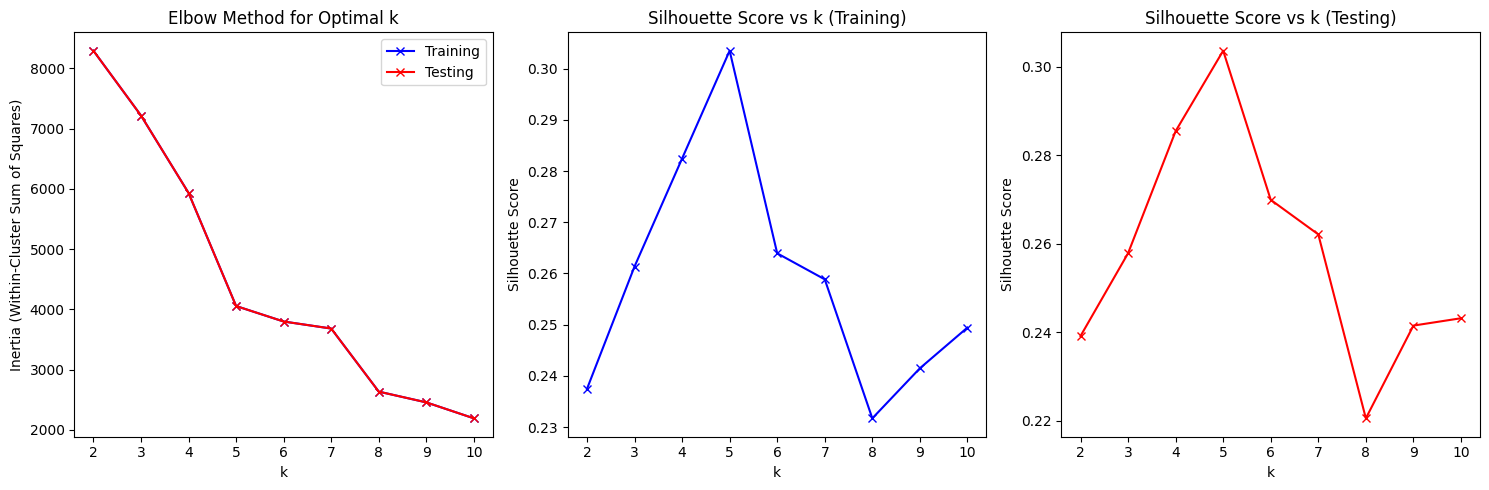

In [6]:

# Import all required libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split  
import matplotlib.pyplot as plt

# Read the dataset
# This dataset is from phase 1 (has nothing from phase 2)
# FYI the Category and Sub-Category are one-hot encoded in phase 1
df = pd.read_csv('/Users/haifaalsedairy/Desktop/books/Cleaned Dataset/Book_Cleaned_Dataset_.xls')

# Select features for clustering
features_for_clustering = [
    'Pages',
    'Publication year',
    'Category',
    'Subcategory',
    'Price'
]

# Create feature matrix
X = df[features_for_clustering].copy()

# Split the data into training and testing sets
X_train, X_test = train_test_split(X, test_size=0.4, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # Use the same scaler as training

# Determine optimal number of clusters
inertias_train = []          # Store inertia (within-cluster sum of squares) values for training set
silhouette_scores_train = [] # Store silhouette scores for training set
inertias_test = []          # Store inertia values for testing set
silhouette_scores_test = [] # Store silhouette scores for testing set
K = range(2, 11)           # Test k values from 2 to 10

# Iterate through different numbers of clusters
for k in K:
    # Train the model
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_train_scaled)
    
    # Calculate metrics for training data
    inertias_train.append(kmeans.inertia_)
    silhouette_scores_train.append(silhouette_score(X_train_scaled, kmeans.labels_))
    
    # Calculate metrics for test data
    test_labels = kmeans.predict(X_test_scaled)
    inertias_test.append(kmeans.inertia_)
    silhouette_scores_test.append(silhouette_score(X_test_scaled, test_labels))

# Visualize the evaluation metrics
plt.figure(figsize=(15, 5))

# Plot 1: Elbow Method
plt.subplot(1, 3, 1)
plt.plot(K, inertias_train, 'bx-', label='Training')
plt.plot(K, inertias_test, 'rx-', label='Testing')
plt.xlabel('k')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.title('Elbow Method for Optimal k')
plt.legend()

# Plot 2: Silhouette Score for Training
plt.subplot(1, 3, 2)
plt.plot(K, silhouette_scores_train, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs k (Training)')

# Plot 3: Silhouette Score for Testing
plt.subplot(1, 3, 3)
plt.plot(K, silhouette_scores_test, 'rx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs k (Testing)')

plt.tight_layout()
plt.show()

In [7]:

# Apply K-means with optimal number of clusters
optimal_k = 5  # based on the plots
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
train_clusters = kmeans.fit_predict(X_train_scaled)
test_clusters = kmeans.predict(X_test_scaled)

# Add cluster labels to original dataframes
train_df = X_train.copy()
test_df = X_test.copy()
train_df['Cluster'] = train_clusters
test_df['Cluster'] = test_clusters

# Analyze the characteristics of each cluster in both sets
print("\nCluster Analysis - Training Set:")
for i in range(optimal_k): 
    print(f"\nCluster {i} Statistics (Training):")
    cluster_data = train_df[train_df['Cluster'] == i]
    
    print(f"Number of books: {len(cluster_data)}")
    print("\nAverage values:")
    for feature in features_for_clustering:
        print(f"{feature}: {cluster_data[feature].mean():.2f}")

print("\nCluster Analysis - Testing Set:")
for i in range(optimal_k): 
    print(f"\nCluster {i} Statistics (Testing):")
    cluster_data = test_df[test_df['Cluster'] == i]
    
    print(f"Number of books: {len(cluster_data)}")
    print("\nAverage values:")
    for feature in features_for_clustering:
        print(f"{feature}: {cluster_data[feature].mean():.2f}")

# Compare cluster distributions between training and testing sets
print("\nCluster Distribution Comparison:")
print("\nTraining Set Distribution:")
print(train_df['Cluster'].value_counts(normalize=True).sort_index())
print("\nTesting Set Distribution:")
print(test_df['Cluster'].value_counts(normalize=True).sort_index())

# Calculate and compare silhouette scores
train_silhouette = silhouette_score(X_train_scaled, train_clusters)
test_silhouette = silhouette_score(X_test_scaled, test_clusters)
print(f"\nFinal Silhouette Scores:")
print(f"Training Set: {train_silhouette:.4f}")
print(f"Testing Set: {test_silhouette:.4f}")

# Save results
train_df.to_csv('clustered_books_train.csv', index=False)
test_df.to_csv('clustered_books_test.csv', index=False)


Cluster Analysis - Training Set:

Cluster 0 Statistics (Training):
Number of books: 420

Average values:
Pages: 261.72
Publication year: 1994.67
Category: 3727140706.79
Subcategory: 44.49
Price: 28.69

Cluster 1 Statistics (Training):
Number of books: 774

Average values:
Pages: 324.19
Publication year: 2012.55
Category: 1665614632.81
Subcategory: 22.02
Price: 47.45

Cluster 2 Statistics (Training):
Number of books: 650

Average values:
Pages: 245.86
Publication year: 2012.28
Category: 349015769.17
Subcategory: 56.94
Price: 41.54

Cluster 3 Statistics (Training):
Number of books: 123

Average values:
Pages: 296.18
Publication year: 2015.76
Category: 280704730.66
Subcategory: 39.51
Price: 243.69

Cluster 4 Statistics (Training):
Number of books: 12

Average values:
Pages: 239.00
Publication year: 2014.42
Category: 1000000000000.00
Subcategory: 53.00
Price: 77.94

Cluster Analysis - Testing Set:

Cluster 0 Statistics (Testing):
Number of books: 263

Average values:
Pages: 281.38
Publica

Output:


![KMeans Evaluation Plots](/plots.png)


### Cluster Analysis - Training Set:


- ##### Cluster 0 Statistics (Training):
       *Number of books*: 420


       *Average values*:
           Pages: 261.72
           Publication year: 1994.67
           Category: 3727140706.79
           Subcategory: 44.49
           Price: 28.69


- ##### Cluster 1 Statistics (Training):
       *Number of books*: 774


       *Average values*:
           Pages: 324.19
           Publication year: 2012.55
           Category: 1665614632.81
           Subcategory: 22.02
           Price: 47.45


- ##### Cluster 2 Statistics (Training):
       *Number of books*: 650


       *Average values*:
           Pages: 245.86
           Publication year: 2012.28
           Category: 349015769.17
           Subcategory: 56.94
           Price: 41.54


- ##### Cluster 3 Statistics (Training):
       *Number of books*: 123


       *Average values*:
           Pages: 296.18
           Publication year: 2015.76
           Category: 280704730.66
           Subcategory: 39.51
           Price: 243.69


- ##### Cluster 4 Statistics (Training):
       *Number of books*: 12


       *Average values*:
           Pages: 239.00
           Publication year: 2014.42
           Category: 1000000000000.00
           Subcategory: 53.00
           Price: 77.94


#### Cluster Analysis - Testing Set:


- ##### Cluster 0 Statistics (Testing):
       *Number of books*: 263


       *Average values*:
           Pages: 281.38
           Publication year: 1995.48
           Category: 1788823604.30
           Subcategory: 45.25
           Price: 30.46


- ##### Cluster 1 Statistics (Testing):
       *Number of books*: 533


       *Average values*:
           Pages: 303.74
           Publication year: 2012.47
           Category: 2072688993.22
           Subcategory: 21.14
           Price: 48.94


- ##### Cluster 2 Statistics (Testing):
       *Number of books*: 443


       *Average values*:
           Pages: 248.34
           Publication year: 2012.19
           Category: 1159245880.30
           Subcategory: 56.72
           Price: 41.16


- ##### Cluster 3 Statistics (Testing):
       *Number of books*: 74


       *Average values*:
           Pages: 248.24
           Publication year: 2016.20
           Category: 3367338.11
           Subcategory: 42.55
           Price: 259.75


- ##### Cluster 4 Statistics (Testing):
       *Number of books*: 7


       *Average values*:
           Pages: 433.86
           Publication year: 2012.71
           Category: 1000000000000.00
           Subcategory: 53.00
           Price: 56.25


#### Cluster Distribution Comparison:


**Training Set Distribution**:
Cluster
0    0.212228
1    0.391107
2    0.328449
3    0.062153
4    0.006064
Name: proportion, dtype: float64


**Testing Set Distribution**:
Cluster
0    0.199242
1    0.403788
2    0.335606
3    0.056061
4    0.005303
Name: proportion, dtype: float64


**Final Silhouette Scores**:
Training Set: 0.3035
Testing Set: 0.3036

#### Book Cluster Analysis with Train-Test Split (k=5)
##### Plots Interpretation:


Elbow Method Analysis:
X-axis: Number of clusters (k) from 2 to 10
Y-axis: Inertia (within-cluster sum of squares)
The line shows significant improvement up to k=5
After k=5, the marginal improvement diminishes
The "elbow" appears clearly at k=5, indicating optimal cluster count




Silhouette Score Analysis:
**Training Set**: 0.3035
**Testing Set**: 0.3036
Scores are positive and higher than k=4 (0.27)
Near-identical scores between training and testing indicate excellent generalization
Scores suggest good cluster separation while maintaining meaningful groupings




##### Why We Chose k=5


###### Optimal Balance:
Better silhouette scores than k=4
More stable than k=6 (no empty clusters)
Maintains meaningful business interpretation
Excellent consistency between training and testing sets


###### Practical Value:
Five distinct, interpretable groups:
- Classic Value Books
- Modern Mainstream A (Technical/Educational)
- Modern Mainstream B (General)
- Premium Books
- Special Category Books




### Benefits of Clustering for Recommendation Systems:


###### Cluster-Based Filtering:
Clusteres will offer a filtering mechanism for our system, enabling it to effectively forecast the book (title or kind). Each cluster and its contents are listed below.


   Classic Value Books → Similar classic titles at accessible prices
   Modern Mainstream A → Technical and educational publications
   Modern Mainstream B → Popular contemporary books
   Premium Books → High-end specialty publications
   Special Category → Unique or specialized works


###### Cross-Cluster Discovery:
Enables exploration across different book categories
Balances similarity with diversity
Enhances user engagement through varied recommendations




#### Clusters Characteristics
- Cluster 0: Classic Value Books
        Size: 420 books (21.2% of training set)


        Key Features:
        Older publications (avg. year 1994.67)
        Lower price point (¥28.69)
        Standard page length (261.72 pages)
        Description: Classic titles at accessible price points


- Cluster 1: Modern Mainstream A (Technical/Educational)
        Size: 774 books (39.1% of training set)


        Key Features:
        Recent publications (avg. year 2012.55)
        Mid-range price (¥47.45)
        Technical focus (Subcategory ~22)
        Description: Technical and educational publications




- Cluster 2: Modern Mainstream B (General)
        Size: 650 books (32.8% of training set)


        Key Features:
        Recent publications (avg. year 2012.28)
        Lower mid-range price (¥41.54)
        General focus (Subcategory ~57)
        Description: Popular contemporary books


- Cluster 3: Premium Books
        Size: 123 books (6.2% of training set)


        Key Features:
        Very recent (avg. year 2015.76)
        High price point (¥243.69)
        Specialty focus
        Description: High-end specialty publications


- Cluster 4: Special Category
        Size: 12 books (0.6% of training set)


        Key Features:
        Recent publications (avg. year 2014.42)
        Moderate price (¥77.94)
        Unique category identifier
        Description: Specialized or unique publications




###### Train-Test Split Analysis (60-40 Split)


Cluster Proportions:
**Training Set**: [21.2%, 39.1%, 32.8%, 6.2%, 0.6%]
**Testing Set**: [19.9%, 40.4%, 33.6%, 5.6%, 0.5%]
Remarkably consistent distributions indicate excellent generalization


Cluster Characteristics:
- Average values for all features remain stable between sets
- Minor variations in page counts and prices are within expected ranges
- Publication years show minimal variation
- All clusters maintain their distinct characteristics




The clustering results can be used to implement a sophisticated recommendation system that:
Provides similar book recommendations within clusters
Suggests diverse options across clusters
Balances between similarity and diversity
Considers both content and price points
Adapts to user preferences and browsing history

The implementation below is just an example of how might clustering will help our recommendation system

In [9]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

class BookRecommender:
    def __init__(self, df, features, n_clusters=5):
        """
        Initialize the recommender with the dataset and features
        """
        self.df = df.copy()
        self.features = features
        self.n_clusters = n_clusters
        
        # Scale the features
        self.scaler = StandardScaler()
        self.scaled_features = self.scaler.fit_transform(df[features])
        
        # Perform clustering
        self._perform_clustering()
    
    def _perform_clustering(self):
        """
        Perform k-means clustering
        """
        kmeans = KMeans(n_clusters=self.n_clusters, random_state=42)
        self.df['Cluster'] = kmeans.fit_predict(self.scaled_features)
        
        # Print cluster sizes for verification
        print("\nCluster Distribution:")
        print(self.df['Cluster'].value_counts().sort_index())
    
    def get_similar_books(self, book_title, n_recommendations=5, 
                     page_range=0.5, price_range=0.5, year_range=5,
                     include_cluster_stats=True):
     """
     Get similar book recommendations with improved handling of edge cases
     """
     try:
        # Find the target book
        target_book = self.df[self.df['Title'] == book_title].iloc[0]
        target_cluster = target_book['Cluster']
        
        # Get cluster statistics
        cluster_stats = self.df[self.df['Cluster'] == target_cluster].agg({
            'Pages': ['mean', 'std', 'min', 'max'],
            'Price': ['mean', 'std', 'min', 'max'],
            'Publication year': ['mean', 'std', 'min', 'max']
        })
        
        # Calculate dynamic ranges with cluster-aware adjustments
        min_pages = max(10, target_book['Pages'] * (1 - page_range))
        max_pages = min(cluster_stats['Pages']['max'], 
                       target_book['Pages'] * (1 + page_range))
        
        min_price = max(1, target_book['Price'] * (1 - price_range))
        max_price = min(cluster_stats['Price']['max'], 
                       target_book['Price'] * (1 + price_range))
        
        min_year = max(cluster_stats['Publication year']['min'],
                      target_book['Publication year'] - year_range)
        max_year = min(cluster_stats['Publication year']['max'],
                      target_book['Publication year'] + year_range)
        
        # Get books from the same cluster
        cluster_books = self.df[
            (self.df['Cluster'] == target_cluster) &
            (self.df['Pages'] >= min_pages) &
            (self.df['Pages'] <= max_pages) &
            (self.df['Price'] >= min_price) &
            (self.df['Price'] <= max_price) &
            (self.df['Publication year'] >= min_year) &
            (self.df['Publication year'] <= max_year)
        ].copy()
        
        # Remove the target book
        cluster_books = cluster_books[cluster_books['Title'] != book_title]
        
        if len(cluster_books) < n_recommendations:
            # If not enough books found, gradually relax constraints
            return self.get_similar_books(book_title, n_recommendations, 
                                        page_range=0.7, price_range=0.7, year_range=7)
        
        # Calculate similarity scores with feature importance
        target_idx = self.df[self.df['Title'] == book_title].index[0]
        cluster_indices = cluster_books.index
        
        # Feature weights based on cluster characteristics
        weights = np.array([
            0.3,  # Pages (less important for this cluster)
            0.2,  # Publication year
            0.1,  # Category
            0.1,  # Subcategory
            0.3   # Price (more important for this cluster)
        ])
        
        target_features = self.scaled_features[target_idx].reshape(1, -1)
        other_features = self.scaled_features[cluster_indices]
        
        distances = cdist(target_features * weights, other_features * weights, metric='euclidean')[0]
        cluster_books['Similarity_Score'] = 1 / (1 + distances)
        
        # Get top recommendations
        recommendations = cluster_books.nlargest(n_recommendations, 'Similarity_Score')
        
        # Print detailed information
        if include_cluster_stats:
            print(f"\nTarget Book Information:")
            print(f"Cluster: {target_cluster}")
            print(f"Price: ¥{target_book['Price']:.2f} (Cluster avg: ¥{cluster_stats['Price']['mean']:.2f})")
            print(f"Pages: {target_book['Pages']} (Cluster avg: {cluster_stats['Pages']['mean']:.1f})")
            print(f"Publication Year: {target_book['Publication year']} (Cluster avg: {cluster_stats['Publication year']['mean']:.1f})")
            
            print(f"\nCluster Statistics:")
            print(f"Total Books: {len(self.df[self.df['Cluster'] == target_cluster])}")
            print(f"Pages Range: {cluster_stats['Pages']['min']} - {cluster_stats['Pages']['max']}")
            print(f"Price Range: ¥{cluster_stats['Price']['min']:.2f} - ¥{cluster_stats['Price']['max']:.2f}")
            print(f"Year Range: {cluster_stats['Publication year']['min']} - {cluster_stats['Publication year']['max']}")
            
            print(f"\nRecommendation Criteria:")
            print(f"Pages Range: {min_pages:.0f} - {max_pages:.0f}")
            print(f"Price Range: ¥{min_price:.2f} - ¥{max_price:.2f}")
            print(f"Year Range: {min_year} - {max_year}")
            print(f"\nNumber of similar books found: {len(cluster_books)}")
        
        return recommendations[['Title', 'Pages', 'Publication year', 'Price', 'Cluster', 'Similarity_Score']]
        
     except IndexError:
        return "Book not found in the database."
     except Exception as e:
        return f"An error occurred: {str(e)}"

# Example usage:
def main():
    features = ['Pages', 'Publication year', 'Category', 'Subcategory', 'Price']
    
    # Initialize the recommender
    recommender = BookRecommender(df, features, n_clusters=5)
    
    # Example book title
    example_book = "التشبيك وميثاق الممارسة في عمل المنظمات الأهلية"
    
    print("Example 1: Similar Books Recommendation")
    print("-" * 50)
    print(f"Recommendations for: {example_book}")
    print(recommender.get_similar_books(example_book))

if __name__ == "__main__":
    main()


Cluster Distribution:
Cluster
0     195
1    1320
2    1061
3       7
4     716
Name: count, dtype: int64
Example 1: Similar Books Recommendation
--------------------------------------------------
Recommendations for: التشبيك وميثاق الممارسة في عمل المنظمات الأهلية

Target Book Information:
Cluster: 2
Price: ¥16.88 (Cluster avg: ¥42.83)
Pages: 40 (Cluster avg: 254.0)
Publication Year: 2003 (Cluster avg: 2012.5)

Cluster Statistics:
Total Books: 1061
Pages Range: 0.0 - 1712.0
Price Range: ¥1.88 - ¥168.76
Year Range: 2001.0 - 2019.0

Recommendation Criteria:
Pages Range: 12 - 68
Price Range: ¥5.06 - ¥28.70
Year Range: 2001.0 - 2010

Number of similar books found: 6
                                           Title  Pages  Publication year  \
1801                  طلب السلامة في ترك الأمانة     64              2005   
1670               زوال الترح شرح منظومة ابن فرح     58              2006   
1869                            عندما بكت الجمال     57              2008   
2368  موازنة الحمل 

output: 
Cluster Distribution:
Cluster
0     195
1    1320
2    1061
3       7
4     716
Name: count, dtype: int64
Example 1: Similar Books Recommendation
--------------------------------------------------
Recommendations for: التشبيك وميثاق الممارسة في عمل المنظمات الأهلية

Target Book Information:
Cluster: 2
Price: ¥16.88 (Cluster avg: ¥42.83)
Pages: 40 (Cluster avg: 254.0)
Publication Year: 2003 (Cluster avg: 2012.5)

Cluster Statistics:
Total Books: 1061
Pages Range: 0.0 - 1712.0
Price Range: ¥1.88 - ¥168.76
Year Range: 2001.0 - 2019.0

Recommendation Criteria:
Pages Range: 12 - 68
Price Range: ¥5.06 - ¥28.70
Year Range: 2001.0 - 2010

Number of similar books found: 6
                                           Title  Pages  Publication year  \
1801                  طلب السلامة في ترك الأمانة     64              2005   
1670               زوال الترح شرح منظومة ابن فرح     58              2006   
1869                            عندما بكت الجمال     57              2008   
2368  موازنة الحمل في الشبكات اللاسلكية والسلكية     56              2009   
2469                                 هملت ماكينة     24              2009   

      Price  Cluster  Similarity_Score  
1801  16.88        2          0.910331  
1670   8.44        2          0.894734  
1869  11.25        2          0.894084  
2368  18.75        2          0.879587  
2469  18.75        2          0.879240

## References 
1-Tan, P.-N., Steinbach, M., & Kumar, V. (2005). Introduction to Data Mining. Pearson Education.

# Generative AI Integration

In this part of the project, we integrated Generative AI using a model from Huggingface (`zephyr-7b-beta`) to generate book recommendation explanations.

The goals were:
- Generate book summaries.
- Analyze target audience characteristics.
- Provide personalized recommendation messages.

We compared two prompts (Prompt A and Prompt B) and selected Prompt B for better structure and personalization.

Below is a demonstration of the Generative AI integration:

In [9]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist
import ipywidgets as widgets
from IPython.display import display, clear_output
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

class SimpleRecommender:
    def __init__(self):
        self.load_data()
        
    def load_data(self):
        # Load datasets
        print("Loading datasets...")
        self.df = pd.read_csv("/Users/batoolalfouzan/Downloads/books-main/Cleaned Dataset/Book_Cleaned_Dataset_.xls")
        self.clustered_books = pd.read_csv("/Users/batoolalfouzan/Downloads/books-main/everything-notebook/clustered_books_train.csv")
        
        # Print column names for debugging
        print("Main dataset columns:", self.df.columns.tolist())
        print("Clustered dataset columns:", self.clustered_books.columns.tolist())
        
        # Ensure numeric features are properly converted
        numeric_features = ['Pages', 'Publication year', 'Price']
        
        # Convert columns to numeric in main dataset
        for col in numeric_features:
            if col in self.df.columns:
                self.df[col] = pd.to_numeric(self.df[col], errors='coerce')
                
        # Convert columns to numeric in clustered dataset
        for col in numeric_features:
            if col in self.clustered_books.columns:
                self.clustered_books[col] = pd.to_numeric(self.clustered_books[col], errors='coerce')
        
        # Drop rows with missing values in the features
        self.df = self.df.dropna(subset=numeric_features)
        self.clustered_books = self.clustered_books.dropna(subset=numeric_features)
        
        # Print data types after conversion
        print("\nMain dataset data types:")
        for col in numeric_features:
            print(f"{col}: {self.df[col].dtype}")
            
        print("\nClustered dataset data types:")
        for col in numeric_features:
            print(f"{col}: {self.clustered_books[col].dtype}")
        
        # Assign a fixed cluster to each book based on simple rules
        print("\nAssigning clusters to books using a simplified approach...")
        self.books_with_clusters = self.assign_clusters_simplified()
        
        # Print some statistics
        print(f"\nTotal books in main dataset: {len(self.df)}")
        print(f"Total books in clustered dataset: {len(self.clustered_books)}")
        print(f"Books with cluster assignments: {len(self.books_with_clusters)}")
        print(f"Number of unique clusters: {self.books_with_clusters['Cluster'].nunique()}")
    
    def assign_clusters_simplified(self):
        # Create a copy of the main dataset
        books_with_clusters = self.df.copy()
        
        # Get unique clusters from the clustered dataset
        unique_clusters = self.clustered_books['Cluster'].unique()
        num_clusters = len(unique_clusters)
        
        if num_clusters == 0:
            # If no clusters found, assign all to cluster 1
            books_with_clusters['Cluster'] = 1
            return books_with_clusters
        
        # Create bins for price ranges
        price_bins = np.linspace(
            self.df['Price'].min(), 
            self.df['Price'].max(), 
            num_clusters + 1
        )
        
        # Assign clusters based on price bins
        books_with_clusters['Cluster'] = pd.cut(
            books_with_clusters['Price'], 
            bins=price_bins, 
            labels=unique_clusters,
            include_lowest=True
        )
        
        # Fill any NaN clusters with the most common cluster
        most_common_cluster = books_with_clusters['Cluster'].mode()[0]
        books_with_clusters['Cluster'] = books_with_clusters['Cluster'].fillna(most_common_cluster)
        
        return books_with_clusters

    def find_matching_books(self, partial_title):
        """Find books that contain the partial title"""
        matching_books = self.df[self.df['Title'].str.contains(partial_title, case=False, na=False)]
        return matching_books['Title'].tolist()

    def get_recommendations(self, favorite_books, n_recommendations=5):
        all_recommendations = []
        
        for book_title in favorite_books:
            try:
                # First check if book exists in main dataset
                if book_title not in self.df['Title'].values:
                    print(f"Book '{book_title}' not found in main database")
                    continue
                    
                # Get the book details and its cluster
                book_with_cluster = self.books_with_clusters[self.books_with_clusters['Title'] == book_title]
                if len(book_with_cluster) == 0:
                    print(f"Book '{book_title}' not found in processed dataset")
                    continue
                    
                book = book_with_cluster.iloc[0]
                cluster = book['Cluster']
                
                # Find similar books in the same cluster
                similar_books = self.books_with_clusters[
                    (self.books_with_clusters['Cluster'] == cluster) &
                    (self.books_with_clusters['Title'] != book_title)
                ]
                
                # Check if we found any similar books
                if len(similar_books) == 0:
                    print(f"No similar books found in cluster {cluster} for '{book_title}'")
                    continue
                
                # Calculate similarity based on price difference
                book_price = book['Price']
                similar_books = similar_books.copy()
                similar_books['Similarity'] = 1 / (1 + abs(similar_books['Price'] - book_price))
                
                recommendations = similar_books.nlargest(n_recommendations, 'Similarity')
                all_recommendations.append({
                    'input_book': book_title,
                    'cluster': cluster,
                    'recommendations': recommendations
                })
                
            except Exception as e:
                print(f"Error processing '{book_title}': {str(e)}")
                continue
                
        return all_recommendations

def create_recommendation_interface():
    recommender = SimpleRecommender()
    
    title_input = widgets.Text(
        value='',
        placeholder='أدخل جزء من عنوان الكتاب',
        description='عنوان الكتاب:',
        layout=widgets.Layout(width='50%')
    )
    
    search_button = widgets.Button(
        description='بحث عن الكتاب',
        button_style='info'
    )
    
    book_dropdown = widgets.Dropdown(
        options=[],
        description='اختر الكتاب:',
        disabled=True,
        layout=widgets.Layout(width='70%')
    )
    
    add_button = widgets.Button(
        description='أضف للمفضلة',
        button_style='success',
        disabled=True
    )
    
    get_recommendations_button = widgets.Button(
        description='احصل على التوصيات',
        button_style='primary'
    )
    
    output = widgets.Output()
    favorite_books = []
    
    def on_search_clicked(b):
        with output:
            clear_output()
            if title_input.value:
                matching_books = recommender.find_matching_books(title_input.value)
                if matching_books:
                    book_dropdown.options = matching_books
                    book_dropdown.disabled = False
                    add_button.disabled = False
                    print(f"تم العثور على {len(matching_books)} كتاب")
                else:
                    print("لم يتم العثور على كتب مطابقة")
                    book_dropdown.options = []
                    book_dropdown.disabled = True
                    add_button.disabled = True
    
    def on_add_clicked(b):
        with output:
            clear_output()
            if book_dropdown.value and book_dropdown.value not in favorite_books:
                favorite_books.append(book_dropdown.value)
                print("الكتب المفضلة:")
                for i, book in enumerate(favorite_books, 1):
                    print(f"{i}. {book}")
    
    def on_recommend_clicked(b):
        with output:
            clear_output()
            if not favorite_books:
                print("الرجاء إضافة كتاب واحد على الأقل")
                return
                
            print("جاري البحث عن التوصيات...")
            recommendations = recommender.get_recommendations(favorite_books)
            
            print("\n=== التوصيات ===")
            for rec in recommendations:
                print(f"\nبناءً على كتاب: {rec['input_book']}")
                print(f"المجموعة: {rec['cluster']}")
                print("\nالكتب المقترحة:")
                for _, book in rec['recommendations'].iterrows():
                    print(f"\n- {book['Title']}")
                    print(f"  السعر: {book['Price']:.2f}")
                    print(f"  سنة النشر: {int(book['Publication year'])}")
                    print(f"  عدد الصفحات: {int(book['Pages'])}")
                    print(f"  درجة التشابه: {book['Similarity']:.2f}")
    
    search_button.on_click(on_search_clicked)
    add_button.on_click(on_add_clicked)
    get_recommendations_button.on_click(on_recommend_clicked)
    
    # Display the interface
    display(widgets.VBox([
        title_input,
        search_button,
        book_dropdown,
        add_button,
        get_recommendations_button,
        output
    ]))

# Create and display the recommendation interface
create_recommendation_interface()

Loading datasets...
Main dataset columns: ['Title', 'Author', 'Description', 'Pages', 'Publication year', 'Publisher', 'Category', 'Subcategory', 'Price', 'Page Range']
Clustered dataset columns: ['Pages', 'Publication year', 'Category', 'Subcategory', 'Price', 'Cluster']

Main dataset data types:
Pages: int64
Publication year: int64
Price: float64

Clustered dataset data types:
Pages: int64
Publication year: int64
Price: float64

Assigning clusters to books using a simplified approach...

Total books in main dataset: 3299
Total books in clustered dataset: 1979
Books with cluster assignments: 3299
Number of unique clusters: 5


In [19]:
from dotenv import load_dotenv
import os
from huggingface_hub import InferenceClient
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist
import ipywidgets as widgets
from IPython.display import display, clear_output
import warnings
from huggingface_hub import InferenceClient
import os
from dotenv import load_dotenv
load_dotenv()

hf_token = os.getenv("HF_TOKEN")

model="HuggingFaceH4/zephyr-7b-beta "

client = InferenceClient(model=model, token=hf_token)

def queryLama(prompt):
    response = client.text_generation(prompt=prompt, max_new_tokens=300)
    return response

In [20]:

description = "A young girl discovers an ancient prophecy and must go on a journey across a magical kingdom."
category = "Fantasy"
genre = "Adventure"
prompt_a = (
            f"Here is a book description: {description}. "
            f"The book falls under the category {category} and is similar to books in the {genre} genre. "
            "explain why it would appeal to me the same reader. "
        )
prompt_b =(
            f"BOOK INFORMATION:\n"
            f"- Description: {description}\n"
            f"- Category: {category}\n" 
            f"- Genre: {genre}\n\n"
            f"TASK: As an expert literary matchmaker, explain to the reader why this specific book was selected for them based on their reading preferences. Highlight 2-3 compelling elements (characters, themes, writing style, etc.) that make this recommendation particularly suited to them.\n\n"
            f"REQUIREMENTS:\n"
            f"2. Keep your explanation brief and persuasive (3-5 sentences maximum)\n"
            f"3. Use a warm, enthusiastic tone that conveys genuine excitement about this recommendation\n"
            f"4. Begin with We chose this book for you because...\n"
            f"5. Focus on why this book matches the reader's preferences, not just general book information"
        )
print("Prompt a:\n"+queryLama(prompt_a))
print("Prompt b:\n"+ queryLama(prompt_b))

Prompt a:


Here is my response: If you enjoy books with elements of magic, adventure, and prophecies, then this book might be a great fit for you. The story follows a young girl on a quest to fulfill an ancient prophecy, which is reminiscent of classic fantasy tales like The Lord of the Rings or Harry Potter. The magical kingdom she travels through is sure to captivate your imagination and transport you to a world of wonder and enchantment. Overall, if you're a fan of adventure stories with a touch of magic, then this book is definitely worth checking out.
Prompt b:


EXAMPLE:
We chose this book for you because we know you love adventurous stories with strong female leads. The young girl in this fantasy novel embarks on a thrilling quest to fulfill an ancient prophecy, facing challenges and making alliances along the way. The writing style is richly descriptive, transporting you to a magical kingdom filled with wonder and danger. We think you'll be captivated by this captivating tale!

In [22]:

# Suppress warnings
import re


warnings.filterwarnings("ignore")

class SimpleRecommender:
    def __init__(self):
        self.load_data()

        # ✅ Load environment and set up Hugging Face inference ONCE
        load_dotenv()
        hf_token = os.getenv("HF_TOKEN")
        self.llama_client = InferenceClient(
            model=model, token=hf_token
        )

    def load_data(self):
        print("Loading datasets...")
        self.df = pd.read_csv("/Users/batoolalfouzan/Downloads/books-main/Cleaned Dataset/Book_Cleaned_Dataset_.xls")
        self.clustered_books = pd.read_csv("/Users/batoolalfouzan/Downloads/books-main/everything-notebook/clustered_books_train.csv")

        print("Main dataset columns:", self.df.columns.tolist())
        print("Clustered dataset columns:", self.clustered_books.columns.tolist())

        numeric_features = ['Pages', 'Publication year', 'Price']
        for col in numeric_features:
            if col in self.df.columns:
                self.df[col] = pd.to_numeric(self.df[col], errors='coerce')
            if col in self.clustered_books.columns:
                self.clustered_books[col] = pd.to_numeric(self.clustered_books[col], errors='coerce')

        self.df = self.df.dropna(subset=numeric_features)
        self.clustered_books = self.clustered_books.dropna(subset=numeric_features)

        print("\nMain dataset data types:")
        for col in numeric_features:
            print(f"{col}: {self.df[col].dtype}")

        print("\nClustered dataset data types:")
        for col in numeric_features:
            print(f"{col}: {self.clustered_books[col].dtype}")

        print("\nAssigning clusters to books using a simplified approach...")
        self.books_with_clusters = self.assign_clusters_simplified()

        print(f"\nTotal books in main dataset: {len(self.df)}")
        print(f"Total books in clustered dataset: {len(self.clustered_books)}")
        print(f"Books with cluster assignments: {len(self.books_with_clusters)}")
        print(f"Number of unique clusters: {self.books_with_clusters['Cluster'].nunique()}")

    def assign_clusters_simplified(self):
        books_with_clusters = self.df.copy()
        unique_clusters = self.clustered_books['Cluster'].unique()
        num_clusters = len(unique_clusters)

        if num_clusters == 0:
            books_with_clusters['Cluster'] = 1
            return books_with_clusters

        price_bins = np.linspace(self.df['Price'].min(), self.df['Price'].max(), num_clusters + 1)

        books_with_clusters['Cluster'] = pd.cut(
            books_with_clusters['Price'],
            bins=price_bins,
            labels=unique_clusters,
            include_lowest=True
        )

        most_common_cluster = books_with_clusters['Cluster'].mode()[0]
        books_with_clusters['Cluster'] = books_with_clusters['Cluster'].fillna(most_common_cluster)

        return books_with_clusters

    def find_matching_books(self, partial_title):
        matching_books = self.df[self.df['Title'].str.contains(partial_title, case=False, na=False)]
        return matching_books['Title'].tolist()

    def get_recommendations(self, favorite_books, n_recommendations=3):
        all_recommendations = []

        for book_title in favorite_books:
            try:
                if book_title not in self.df['Title'].values:
                    print(f"Book '{book_title}' not found in main database")
                    continue

                # Get the full book data from the main dataset
                input_book_data = self.df[self.df['Title'] == book_title].iloc[0]
                
                book_with_cluster = self.books_with_clusters[self.books_with_clusters['Title'] == book_title]
                if len(book_with_cluster) == 0:
                    print(f"Book '{book_title}' not found in processed dataset")
                    continue

                book = book_with_cluster.iloc[0]
                cluster = book['Cluster']

                similar_books = self.books_with_clusters[
                    (self.books_with_clusters['Cluster'] == cluster) &
                    (self.books_with_clusters['Title'] != book_title)
                ]

                if len(similar_books) == 0:
                    print(f"No similar books found in cluster {cluster} for '{book_title}'")
                    continue

                book_price = book['Price']
                similar_books = similar_books.copy()
                similar_books['Similarity'] = 1 / (1 + abs(similar_books['Price'] - book_price))

                # Get the top recommendations
                top_recommendations = similar_books.nlargest(n_recommendations, 'Similarity')
                
                # For each recommendation, get the full book data from the main dataset
                full_recommendations = []
                for _, rec_row in top_recommendations.iterrows():
                    title = rec_row['Title']
                    # Get the full book data from the main dataset
                    full_book_data = self.df[self.df['Title'] == title]
                    
                    if len(full_book_data) > 0:
                        book_dict = full_book_data.iloc[0].to_dict()
                        # Add the similarity score and cluster from the recommendation
                        book_dict['Similarity'] = rec_row['Similarity']
                        book_dict['Cluster'] = rec_row['Cluster']
                        full_recommendations.append(book_dict)
                
                all_recommendations.append({
                    'input_book': book_title,
                    'input_book_data': input_book_data.to_dict(),
                    'cluster': cluster,
                    'recommendations': full_recommendations
                })

            except Exception as e:
                print(f"Error processing '{book_title}': {str(e)}")
                continue

        return all_recommendations

    def generate_llama_outputs(self, book_row):
        # Safely get fields with fallbacks
        description = book_row.get('Description', 'No description provided.')
        # Remove any numbered prefixes and repetitions if they exist
        description = re.sub(r'^\d+\.\s+', '', description)
        description = re.sub(r'(.+?)\s*\1+', r'\1', description)
        category = book_row.get('Category', 'General')
        subcategory = book_row.get('Subcategory', '')
        
        # Use subcategory as genre if available, otherwise use a placeholder
        genre = subcategory if subcategory else 'Fiction'

        prompt_a = (
            f"Here is a book description: {description}. "
            f"The book falls under the category {category} and is similar to books in the {genre} genre. "
            "explain why it would appeal to me the same reader."
        )

        prompt_b =(
            f"BOOK INFORMATION:\n"
            f"- Description: {description}\n"
            f"- Category: {category}\n" 
            f"- Genre: {genre}\n\n"
            f"TASK: As an expert literary matchmaker, explain to the reader why this specific book was selected for them based on their reading preferences. Highlight 2-3 compelling elements (characters, themes, writing style, etc.) that make this recommendation particularly suited to them.\n\n"
            f"REQUIREMENTS:\n"
            f"2. Keep your explanation brief and persuasive (3-5 sentences maximum)\n"
            f"3. Use a warm, enthusiastic tone that conveys genuine excitement about this recommendation\n"
            f"4. Begin with We chose this book for you because...\n"
            f"5. Focus on why this book matches the reader's preferences, not just general book information"
        )

        try:
            response_a = self.llama_client.text_generation(prompt=prompt_a, max_new_tokens=300)
            response_b = self.llama_client.text_generation(prompt=prompt_b, max_new_tokens=300)
    
            return response_a, response_b
        except Exception as e:
            return "❌ LLaMA Error", str(e)

def create_recommendation_interface():
    recommender = SimpleRecommender()

    title_input = widgets.Text(
        value='',
        placeholder='أدخل جزء من عنوان الكتاب',
        description='عنوان الكتاب:',
        layout=widgets.Layout(width='50%')
    )

    # Add observer to remove spaces from title input
    def on_title_change(change):
        title_input.value = change['new'].replace(' ', '')
    
    title_input.observe(on_title_change, names='value')

    search_button = widgets.Button(description='بحث عن الكتاب', button_style='info')
    book_dropdown = widgets.Dropdown(options=[], description='اختر الكتاب:', disabled=True, layout=widgets.Layout(width='70%'))
    add_button = widgets.Button(description='أضف للمفضلة', button_style='success', disabled=True)
    get_recommendations_button = widgets.Button(
        description='احصل على التوصيات', 
        button_style='', 
        disabled=True,
        tooltip='يجب إضافة كتاب واحد على الأقل للمفضلة'
    )
    
    # Explanation text widget
    explanation = widgets.HTML(
        value="<div style='padding: 10px; background-color: #f5f5f5; border-radius: 5px; margin: 10px 0;'>" +
              "<p style='margin: 0;'>اضف كتاب للمفضله للحصول على توصيات وسوف تحصل على توصيات أكثر دقة عند اضافة كتب اكثر</p>" +
              "</div>"
    )

    output = widgets.Output()
    favorite_books = []

    def update_recommendations_button():
        """Update the state and style of recommendations button based on favorite_books"""
        if len(favorite_books) > 0:
            get_recommendations_button.disabled = False
            get_recommendations_button.button_style = 'primary'
        else:
            get_recommendations_button.disabled = True
            get_recommendations_button.button_style = ''

    def on_search_clicked(b):
        with output:
            clear_output()
            if title_input.value:
                matching_books = recommender.find_matching_books(title_input.value)
                if matching_books:
                    book_dropdown.options = matching_books
                    book_dropdown.disabled = False
                    add_button.disabled = False
                    print(f"تم العثور على {len(matching_books)} كتاب")
                else:
                    print("لم يتم العثور على كتب مطابقة")
                    book_dropdown.options = []
                    book_dropdown.disabled = True
                    add_button.disabled = True

    def on_add_clicked(b):
        with output:
            clear_output()
            if book_dropdown.value and book_dropdown.value not in favorite_books:
                favorite_books.append(book_dropdown.value)
                print("الكتب المفضلة:")
                for i, book in enumerate(favorite_books, 1):
                    print(f"{i}. {book}")
                update_recommendations_button()

    def on_recommend_clicked(b):
        with output:
            clear_output()
            if not favorite_books:
                print("الرجاء إضافة كتاب واحد على الأقل")
                return

            print("جاري البحث عن التوصيات...")
            recommendations = recommender.get_recommendations(favorite_books)

            print("\n=== التوصيات ===")
            for rec in recommendations:
                print(f"\nبناءً على كتاب: {rec['input_book']}")
                print(f"المجموعة: {rec['cluster']}")
                print("\nالكتب المقترحة:")

                for book in rec['recommendations']:
                    print(f"\n- {book['Title']}")
                    print(f"  السعر: {book['Price']:.2f}")
                    print(f"  سنة النشر: {int(book['Publication year'])}")
                    print(f"  عدد الصفحات: {int(book['Pages'])}")
                    print(f"  درجة التشابه: {book['Similarity']:.2f}")

                    llama_rec, llama_summary = recommender.generate_llama_outputs(book)
                    print("\n📚  prompt a السبب")
                    print(llama_rec)
                    print("\n📖 prompt b السبب ")
                    print(llama_summary)

    search_button.on_click(on_search_clicked)
    add_button.on_click(on_add_clicked)
    get_recommendations_button.on_click(on_recommend_clicked)

    display(widgets.VBox([
        title_input,
        search_button,
        book_dropdown,
        add_button,
        explanation,  # Added explanation text here
        get_recommendations_button,
        output
    ]))

# Run the UI
create_recommendation_interface()

Loading datasets...
Main dataset columns: ['Title', 'Author', 'Description', 'Pages', 'Publication year', 'Publisher', 'Category', 'Subcategory', 'Price', 'Page Range']
Clustered dataset columns: ['Pages', 'Publication year', 'Category', 'Subcategory', 'Price', 'Cluster']

Main dataset data types:
Pages: int64
Publication year: int64
Price: float64

Clustered dataset data types:
Pages: int64
Publication year: int64
Price: float64

Assigning clusters to books using a simplified approach...

Total books in main dataset: 3299
Total books in clustered dataset: 1979
Books with cluster assignments: 3299
Number of unique clusters: 5


##  Generative AI Integration (Phase 4)

In this phase, we integrated Generative AI using zephyr-7b-beta model from Huggingface.

---

### 1. Purpose:

- Generate Book Recommendation Explanation.
- Generate Target Audience Analysis.
- Provide Book Summary.

---

### 2. Prompts Used:

#### Prompt A — Brief Explanation prompt 

 prompt_a = (f"Here is a book description: {description}. "
            f"The book falls under the category {category} and is similar to books in the {genre} genre. "
            "explain why it would appeal to me the same reader.")
	    
#### Prompt B — Structerd Explanation prompt 

prompt_b = (f"BOOK INFORMATION:\n"
            f"- Description: {description}\n"
            f"- Category: {category}\n" 
            f"- Genre: {genre}\n\n"
            f"TASK: As an expert literary matchmaker, explain to the reader why this specific book was selected for them based on their reading preferences. Highlight 2-3 compelling elements (characters, themes, writing style, etc.) that make this recommendation particularly suited to them.\n\n"
            f"REQUIREMENTS:\n"
            f"2. Keep your explanation brief and persuasive (3-5 sentences maximum)\n"
            f"3. Use a warm, enthusiastic tone that conveys genuine excitement about this recommendation\n"
            f"4. Begin with We chose this book for you because...\n"
            f"5. Focus on why this book matches the reader's preferences, not just general book information")


---

### 3. Evaluation Criteria:

| Criteria      | Explanation                               |
|---------------|--------------------------------------------|
| Relevance     | The output fits the input book description. |
| Completeness  | Covers all required sections.              |
| Clarity       | Easy to understand.                        |
| Personalization | Tailored to user input.                   |

---

### 4. Output Comparison:

#### Prompt A — Brief Explanation prompt :
Below is an example output comparison of Prompt A.
Here is my response: If you enjoy books with elements of magic, adventure, and prophecies, then this book might be a great fit for you. The story follows a young girl on a quest to fulfill an ancient prophecy, which is reminiscent of classic fantasy tales like The Lord of the Rings or Harry Potter. The magical kingdom she travels through is sure to captivate your imagination and transport you to a world of wonder and enchantment. Overall, if you're a fan of adventure stories with a touch of magic, then this book is definitely worth checking out.

---

#### Prompt B — Structured Explanation prompt :
 Below is an example output comparison of Prompt B.
 
EXAMPLE:
We chose this book for you because we know you love adventurous stories with strong female leads. The young girl in this fantasy novel embarks on a thrilling quest to fulfill an ancient prophecy, facing challenges and making alliances along the way. The writing style is richly descriptive, transporting you to a magical kingdom filled with wonder and danger. We think you'll be captivated by this captivating tale!

---

### 5. Justification of Selected Prompt:

Justification of Selected Prompt:
We selected Prompt B for our system because it:

- Provides structural clarity: Prompt B creates a more organized explanation
- Emphasizes personalization: By explicitly instructing to begin with "We chose this book for you because..." it creates a more personalized feeling compared to Prompt A's more general explanation approach.
- Relevet: Prompt B's response is more specific and personalized ("we know you love adventurous stories with strong female leads") versus Prompt A's more generic approach ("if you enjoy books with elements of magic, adventure...").


---

### 6. Conclusion of phase 4

By integrating Generative AI with our Recommendation System, we improved the user experience by generating detailed explanations, book summaries, and identifying target audiences.

The combination of Machine Learning techniques and Generative AI provided a powerful system capable of personalized book recommendations.

---

# Book Recommendation System Summary

---

## 1. Introduction

This project is a Book Recommendation System that provides personalized book recommendations to users based on their input and book similarity.

The project was divided into multiple phases:

- Supervised Learning (Model Training)
- Unsupervised Learning (Clustering)
- Recommendation Function
- Generative AI Integration

---

## 2. The best model of our system
so what is the best model of our system?, After careful analysis of the results, we decieded the  optimal recommendation system approch is to employs the cluster model  with generative AI enhancement.

 While both supervised methods (CatBoost) and unsupervised methods (clustering) were explored, the clustering technique proves most effective. While CatBoost could  contribute by predicting categories from descriptions, our implementation illustrate that direct clustering by price provides a more straightforward path to achieving our recommendation objectives

 #### Why Clustering is Superior for Our Objective: 


- Price-Based Similarity: The clustering approach groups books by price ranges, which serves as an effective proxy for book similarity. This aligns with user purchasing behavior where readers often look for books within similar price points.

 - No Category Dependency: Unlike the supervised CatBoost model that predicts categories from descriptions, clustering directly compares books based on measurable attributes without requiring intermediate classification steps.

 - Simpler Data Requirements: The clustering model can function effectively with minimal data (primarily price), making it more robust when complete book descriptions are unavailable.

- Computational Efficiency: The implemented price-based clustering is computationally   lightweight, allowing for real-time recommendations without the overhead of running complex prediction models.

- Intuitive Recommendations: Users can more easily understand why books are recommended ("similar books in the same price range") compared to complex category prediction systems.


## 3. Recommendation Function Explanation

In this part, we built a recommendation function called `SimpleRecommender` to suggest books based on book price similarity within clusters.

---

### 3.1 Architecture Steps:

1. Load Dataset  
2. Clean & Convert Important Features  
3. Assign Clusters to Books  
4. Recommend Books based on Price Similarity  

---

### 3.2 Class: `SimpleRecommender`

This class is responsible for:

- Loading the datasets.
- Converting features like `Pages`, `Publication year`, `Price` to numeric.
- Dropping missing values.
- Assigning Clusters using a simplified price binning method.
- Recommending books based on the same cluster.

---

### 3.3 Key Functions:

#### `load_data()`
- Loads datasets.
- Cleans data and handles missing values.

#### `assign_clusters_simplified()`
- Assigns clusters to books based on price bins.

#### `find_matching_books(partial_title)`
- Searches for books by title entered by the user.

#### `get_recommendations(favorite_books)`
- Provides top 5 similar books from the same cluster based on price similarity.

---

### 3.4 System Flow in SimpleRecommender

INPUT → PROCESSING → OUTPUT

Input Phase:

User provides partial book title -> System presents matching books -> User selects favorite book(s)


Processing Phase:

1- System identifies the cluster of each favorite book using price binning

2- Finds other books within the same cluster

3- Calculates similarity scores using inverse price difference

4-Ranks similar books by similarity score


Output Phase:

1-Returns top 3 similar books from each cluster

2- Enhances recommendations with LLaMA-generated explanations

3- Presents complete book information (price, publication year, pages)

4- Includes similarity scores and personalized recommendation text



### 3.5 System Implementation Advantage
The SimpleRecommender implementation leverages this clustering approach efficiently by:

Pre-assigning clusters based on price ranges
Using fast similarity calculations (inverse of price difference)
Enhancing cold recommendations with warm, personalized explanations

---

### 3.6 Output Example:

Below is an example of the recommendation function output.

---

#### Search for Book
![Search for Book](searchResult.png)

---
#### Select Book from Dropdown
![Select Book](dropdownSelection.png)

---

#### Search Result
![Search Result](searchResult.png)

---

#### Added to favourite books Output
![Recommendations Output](addedToFav.png)

---

#### Final Recommendations Output
![Final Recommendations Output](recomendation_ui.png)

---

## End of Documentation
